### Importing libraries

In [29]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score,cross_val_predict
import collections
import statistics
%matplotlib inline
plt.style.use('seaborn-pastel')

import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PATH"] += os.pathsep + r'Graphviz2.38\bin'

In [2]:
data = pd.read_csv(r'events_log.csv')
data.timestamp = data.timestamp.astype('str')
data['time'] = data.timestamp.apply(lambda x: datetime.datetime.strptime(x[:-2], '%Y%m%d%H%M%S')) 

In [3]:
data.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,time
0,00000736167c507e8ec225bd9e71f9e5,20160301103842.0,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,2016-03-01 10:38:42
1,00000c69fe345268935463abbfa5d5b3,20160307005226.0,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,2016-03-07 00:52:26
2,00003bfdab715ee59077a3670331b787,20160302145305.0,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,2016-03-02 14:53:05
3,0000465cd7c35ad2bdeafec953e08c1a,20160302222701.0,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,2016-03-02 22:27:01
4,000050cbb4ef5b42b16c4d2cf69e6358,20160302095023.0,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,2016-03-02 09:50:23


In [4]:
data.nunique()

uuid               400165
timestamp          294302
session_id          68028
group                   2
action                  3
checkin                15
page_id            176371
n_results              92
result_position       193
time               294302
dtype: int64

## What is their daily overall clickthrough rate? How does it vary between the groups?



***Overall clickthrough rate:***

In [5]:
data['stamp'] = data.timestamp.apply(lambda x: str(x)[:8] ) #storing the first 8 letters which will uniquely determine the day
sessionids = data[(data.action == 'searchResultPage') & ((data.n_results > 0))].session_id.values
clickthroughdata = data[data.session_id.isin(sessionids)]

In [6]:
d = {}
for stamp in set(data.stamp):
    temp = clickthroughdata[clickthroughdata.stamp == stamp]
    usercountwhoclicked = sum(temp.groupby(['session_id'])['checkin'].count() > 0)
    totalusers = len(temp.groupby(['session_id'])['checkin'].count())
    d[stamp] = usercountwhoclicked/totalusers


In [54]:
d

{'20160303': 0.39754246476328153,
 '20160308': 0.3786366830639494,
 '20160301': 0.3948529411764706,
 '20160304': 0.38167211328976036,
 '20160305': 0.3753835663143539,
 '20160306': 0.38017640902975036,
 '20160302': 0.40414317234616326,
 '20160307': 0.3805016564126834}

In [7]:
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v


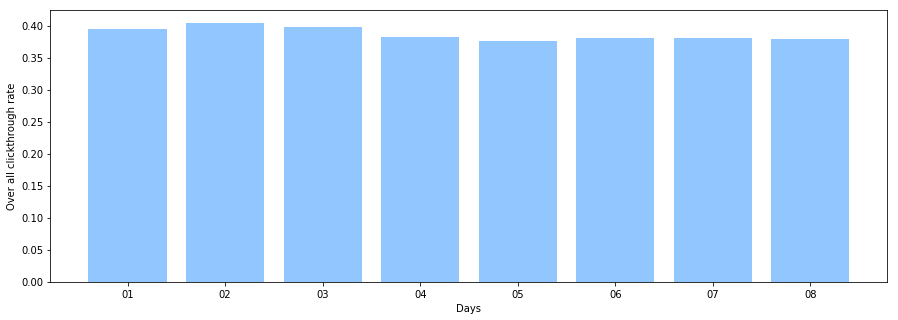

In [8]:
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("Over all clickthrough rate")
plt.show()

***variation between groups:***

In [9]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

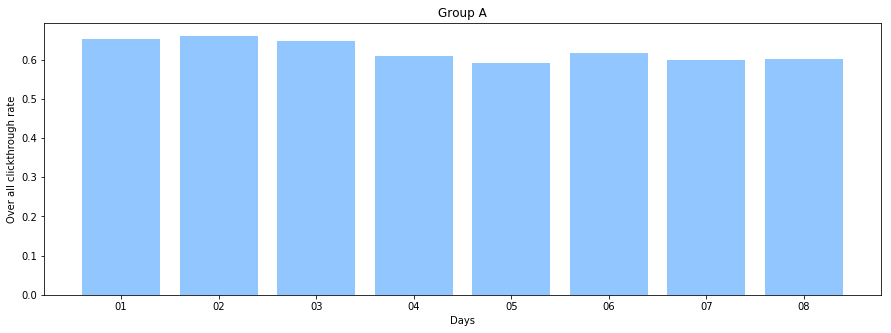

In [10]:
d = {}
for stamp in set(data.stamp):
    temp = A[A.stamp == stamp]
    usercountwhoclicked = sum(temp.groupby(['session_id'])['checkin'].count() > 0)
    totalusers = len(temp.groupby(['session_id'])['checkin'].count())
    d[stamp] = usercountwhoclicked/totalusers

    
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v

    
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("Over all clickthrough rate")
plt.title("Group A")
plt.show()

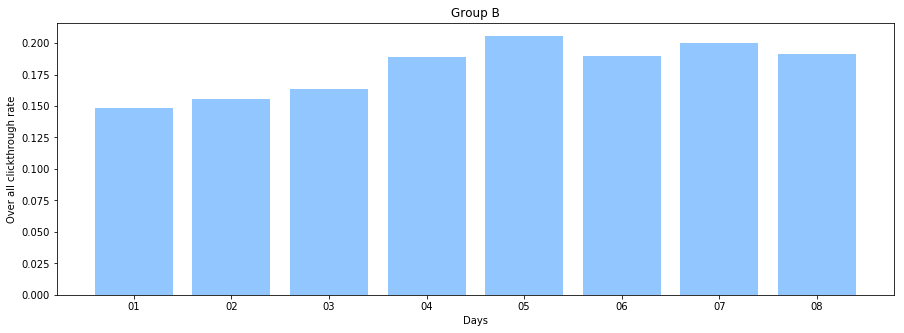

In [11]:
d = {}
for stamp in set(data.stamp):
    temp = B[B.stamp == stamp]
    usercountwhoclicked = sum(temp.groupby(['session_id'])['checkin'].count() > 0)
    totalusers = len(temp.groupby(['session_id'])['checkin'].count())
    d[stamp] = usercountwhoclicked/totalusers

    
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v

    
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("Over all clickthrough rate")
plt.title("Group B")
plt.show()

## Q.  Which result position do people tend to try first? How does it change day-to-day?


In [54]:
d = {}
for stamp in set(data.stamp):
    temp = clickthroughdata[(clickthroughdata.stamp == stamp) & (clickthroughdata.action=='checkin')]
    temp.sort_values(by=['time'],inplace=True)
    t = temp.groupby('session_id')['result_position'].first().values
    d[stamp] = statistics.mode(t)

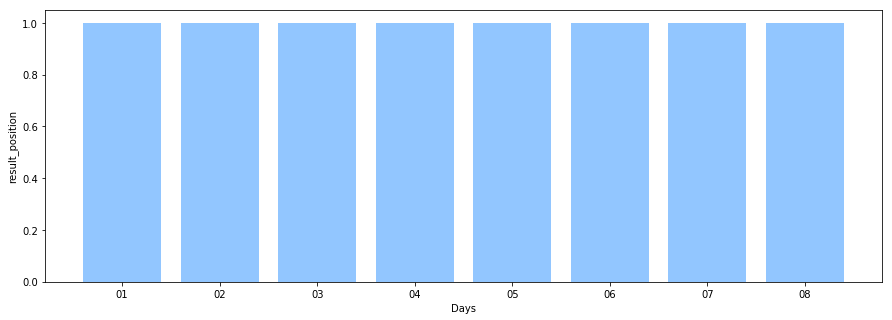

In [58]:
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v

    
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("result_position")
plt.show()

## Q. What is their daily overall zero results rate? How does it vary between the groups?


In [12]:
Zeroresult = data[(data.action == 'searchResultPage') & (data.n_results == 0)]


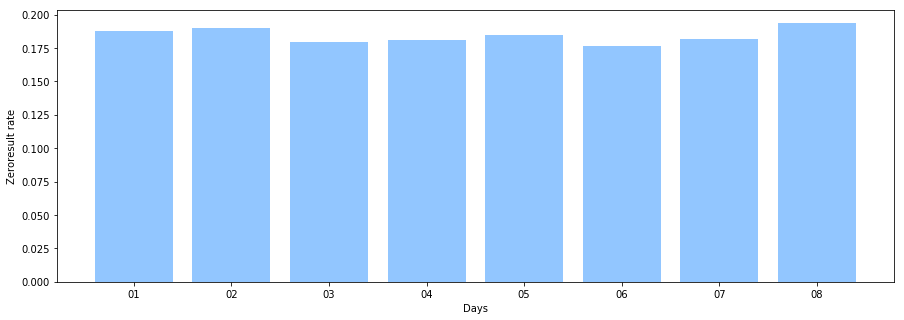

In [13]:
d = {}
for stamp in set(data.stamp):
    temp = Zeroresult[Zeroresult.stamp==stamp]
    d[stamp] = len(temp)/len(data[(data.action == 'searchResultPage') & (data.stamp == stamp)])

    
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v

    
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("Zeroresult rate")
plt.show()

***variation between groups:***

In [14]:
ZA = Zeroresult[Zeroresult.group == 'a']
ZB = Zeroresult[Zeroresult.group == 'b']

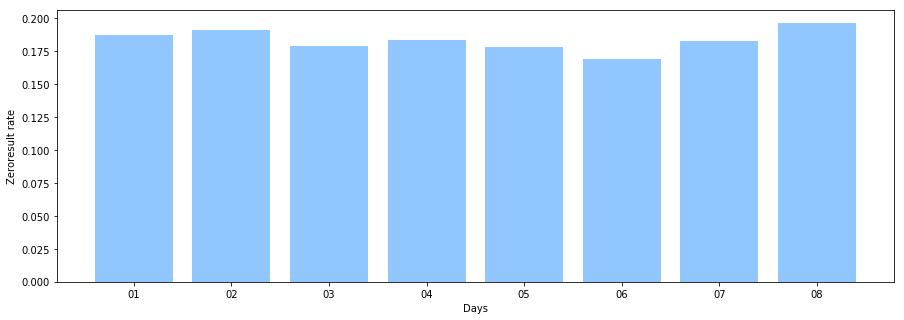

In [15]:
d = {}
for stamp in set(data.stamp):
    temp = ZA[ZA.stamp==stamp]
    d[stamp] = len(temp)/len(data[(data.action == 'searchResultPage') & (data.stamp == stamp) & (data.group == 'a')])

    
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v

    
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("Zeroresult rate")
plt.show()

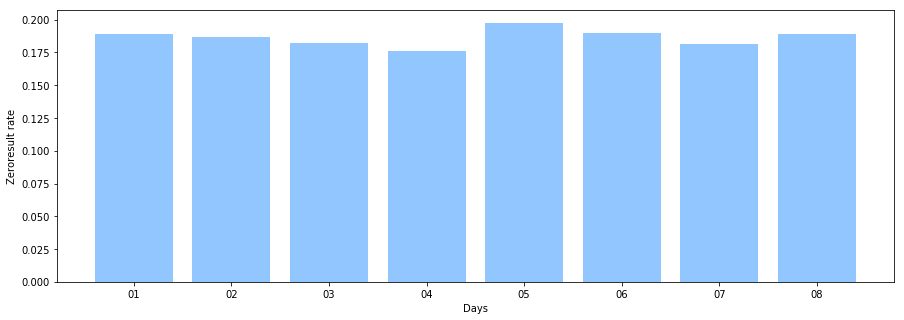

In [16]:
d = {}
for stamp in set(data.stamp):
    temp = ZB[ZB.stamp==stamp]
    d[stamp] = len(temp)/len(data[(data.action == 'searchResultPage') & (data.stamp == stamp) & (data.group == 'b')])

    
od = collections.OrderedDict()
for k,v in sorted(d.items()):
    od[k[6:]] = v

    
plt.figure(figsize=(15,5))
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.xlabel("Days")
plt.ylabel("Zeroresult rate")
plt.show()

## Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.


In [9]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

group_A = A.groupby(['session_id'])['time']
group_B = B.groupby(['session_id'])['time']

In [10]:
start_A = group_A.min() #minimum time for a session id would be the time for first event
end_A = group_A.max() #maximum time for a session id would be the time for last event

start_B = group_B.min() #minimum time for a session id would be the time for first event
end_B = group_B.max() #maximum time for a session id would be the time for last event


In [11]:
(end_A - start_A).mean(),(end_B - start_B).mean()

(Timedelta('0 days 00:04:58.325216'), Timedelta('0 days 00:00:59.605231'))

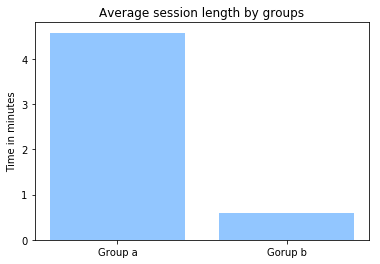

In [12]:
plt.bar(range(2),[4.58,.59])
plt.xticks(range(2),['Group a','Gorup b'])
plt.ylabel("Time in minutes")
plt.title('Average session length by groups')
plt.show()

## Train and Test a simple Classifier to predict if a user is likely to click on one of the search result that appears. Transform the data accordingly. (Bonus points for writing a classifier from scratch) Choose appropriate metrics to measure the performance of your algorithm and visualize the predictions if possible.


***Lets transfrom Data.***

In [46]:
target = clickthroughdata.groupby(['session_id'])['checkin'].count() > 0 #making the target value to whether uer clicked or not
clickthroughdata['clicked'] = clickthroughdata.session_id.apply(lambda x: target[x] )


In [47]:
df = clickthroughdata[clickthroughdata.action == 'searchResultPage']

In [48]:
df['day'] = clickthroughdata.time.apply(lambda x: x.day)
df['hour'] = clickthroughdata.time.apply(lambda x: x.hour)

In [49]:
#Dropping these columns as some of them are constant and some do not have relation to target
df.drop(['uuid','timestamp','session_id','action','page_id','result_position','checkin','time','stamp'],inplace=True,axis=1)
print(df.shape)
df.head()


(123582, 5)


,group,n_results,clicked,day,hour
0,b,5.0,True,1,10
1,a,10.0,False,7,0
7,b,15.0,False,2,1
10,a,20.0,True,7,14
12,a,9.0,True,5,4


In [31]:
target = df.clicked.values
df.drop(['clicked'],axis=1,inplace=True)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [33]:
df.group.replace({'a':0,'b':1},inplace=True)

***Using LightGBM as it as an ensemble type classifier.***

In [34]:
score =  cross_val_score(LGBMClassifier(n_estimators=40,class_weight='balanced'
                                        ,num_leaves=15),df,target,scoring='roc_auc',cv=5)

In [35]:
print('Auc of 5 fold CV: ',score.mean())

Auc of 5 fold CV:  0.7213573874016209


In [37]:
predict = cross_val_predict(LGBMClassifier(n_estimators=40,class_weight='balanced',num_leaves=15),df,target,cv=5)

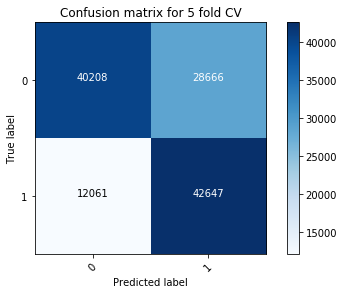

In [39]:
plot_confusion_matrix(metrics.confusion_matrix(target,predict),range(2),title="Confusion matrix for 5 fold CV")

In [41]:
print(metrics.classification_report(target,predict))


             precision    recall  f1-score   support

      False       0.77      0.58      0.66     68874
       True       0.60      0.78      0.68     54708

avg / total       0.69      0.67      0.67    123582



In [43]:
l = LGBMClassifier(n_estimators=40,class_weight='balanced',num_leaves=15).fit(df,target)

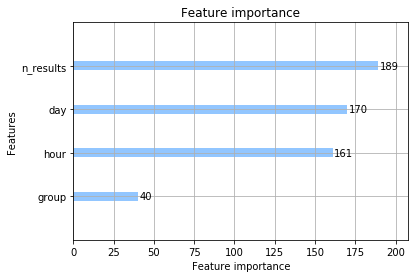

In [44]:
lgb.plot_importance(l)

In [50]:
graph = lgb.create_tree_digraph(l, tree_index=3, name='1') # saving the digram in pdf format
graph.render(view=True)


'1.gv.pdf'

***Let's check if there is some relation to number of result in search with click.***

In [57]:
df[df.clicked == False]['n_results'].mean(),df[df.clicked == True]['n_results'].mean()

(13.716293521503035, 15.627878920815968)

## Summary

 1. Group A users tends to use website more than Group users B.
 2. Group A users have high clickthrough rate means website have topics that are useful to them.
 3. Zero result rate are nearly same for the both type of users.
 4. More number of results usually does not mean that user will click on result.
 